# Two-Particle Electromagnetic Simulation

This notebook reproduces the first two energy plots from the original two_particle_main demo using the fixed Lienard-Wiechert integrator and professional particle initialization.

In [10]:
# Import Required Libraries and Modules
import numpy as np
import matplotlib.pyplot as plt
import time

# Import core electromagnetic simulation modules
from core.performance import OptimizedLienardWiechertIntegrator
from core.particle_initialization import initialize_particle_bunches

# Set professional plotting style
plt.rcParams.update({'font.size': 14})
print("✅ All modules loaded successfully")

✅ All modules loaded successfully


In [11]:
# Reload modules to get latest changes
import importlib
importlib.reload(__import__('core.particle_initialization'))
from core.particle_initialization import initialize_particle_bunches

In [12]:
# Initialize Particle Bunch Parameters (matching original demo exactly)

# Physical constants
c_ms = 299792458
transv_dist = 1e-4

# Particle specifications
rider_params = {
    'particle_mass_amu': 1.007319468,  # proton
    'stripped_ions': 1.0,
    'charge_sign': -1.0,
    'starting_pz': 1.01e6,
    'transv_momentum': 0.0,
    'starting_distance': 1e-6,
    'transv_distance': transv_dist,
    'particle_count': 10
}

driver_params = {
    'particle_mass_amu': 207.2,  # lead
    'stripped_ions': 54.0,
    'charge_sign': 1.0,
    'starting_pz': -rider_params['starting_pz'] / 207.2 * rider_params['particle_mass_amu'],
    'transv_momentum': 0.0,
    'starting_distance': 100.0,
    'particle_count': 10
}

# Integration parameters (matching original)
integration_params = {
    'static_steps': 1,
    'ret_steps': 25,
    'step_size': 2e-6,
    'static_steps2': 1,
    'ret_steps2': 1000,
    'step_size2': 3e-6,
    'sim_type': 2,
    'bunch_dist': 1e5,
    'cav_spacing': 1e5,
    'aperture': 1e5,
    'z_cutoff': 0,
    'wall_pos': 1e5
}

print("✅ Parameters initialized successfully")
print(f"Rider: {rider_params['particle_mass_amu']} amu, charge = {rider_params['charge_sign'] * rider_params['stripped_ions']}")
print(f"Driver: {driver_params['particle_mass_amu']} amu, charge = {driver_params['charge_sign'] * driver_params['stripped_ions']}")

✅ Parameters initialized successfully
Rider: 1.007319468 amu, charge = -1.0
Driver: 207.2 amu, charge = 54.0


In [15]:
# Create and Configure Particle Bunches & Run Simulation (using verified working approach)

# Create particle states directly (matching legacy verification notebook approach)
def create_verified_particle_state(params):
    """Create particle state using verified working format from debugging session."""
    count = params['particle_count']
    
    # Create all required arrays
    state = {
        'x': np.zeros(count),
        'y': np.full(count, transv_dist),  # Use global transv_dist
        'z': np.full(count, params['starting_distance']),
        't': np.zeros(count),
        'px': np.full(count, params['transv_momentum']),
        'py': np.zeros(count),
        'pz': np.full(count, params['starting_pz']),
        'Px': np.full(count, params['transv_momentum']),
        'Py': np.zeros(count),
        'Pz': np.full(count, params['starting_pz']),
        'Pt': np.full(count, np.abs(params['starting_pz'])),
        'bx': np.zeros(count),
        'by': np.zeros(count),
        'bz': np.zeros(count),
        'bdotx': np.zeros(count),
        'bdoty': np.zeros(count),
        'bdotz': np.zeros(count),
        'gamma': np.ones(count),
        'q': np.full(count, params['charge_sign'] * params['stripped_ions']),
        'm': np.full(count, params['particle_mass_amu']),
        'char_time': np.full(count, 1e-15)
    }
    
    rest_energy = params['particle_mass_amu'] * 931.494  # MeV
    return state, rest_energy

# Create particle states using verified format
rider_state, rider_energy_mev = create_verified_particle_state(rider_params)
driver_state, driver_energy_mev = create_verified_particle_state(driver_params)
driver_state['y'] = np.full(driver_params['particle_count'], -transv_dist)  # Opposite side

print(f"✅ Particle bunches initialized:")
print(f"   Rider rest energy: {rider_energy_mev:.2f} MeV")
print(f"   Driver rest energy: {driver_energy_mev:.2f} MeV")

# Create and configure the fixed electromagnetic integrator
integrator = OptimizedLienardWiechertIntegrator()

# Run two-stage integration (matching original demo)
print("\n🔄 Running electromagnetic simulation...")
start_time = time.time()

# Stage 1: Coarse integration
rider_traj_1, driver_traj_1 = integrator.integrate_retarded_fields(
    integration_params['static_steps'], integration_params['ret_steps'], integration_params['step_size'],
    integration_params['wall_pos'], integration_params['aperture'], integration_params['sim_type'],
    rider_state, driver_state,
    integration_params['bunch_dist'], integration_params['z_cutoff'], integration_params['cav_spacing']
)

# Stage 2: Fine integration (interaction zone)
rider_trajectory, driver_trajectory = integrator.integrate_retarded_fields(
    integration_params['static_steps2'], integration_params['ret_steps2'], integration_params['step_size2'],
    integration_params['wall_pos'], integration_params['aperture'], integration_params['sim_type'],
    rider_traj_1[-1], driver_traj_1[-1],
    integration_params['bunch_dist'], integration_params['z_cutoff'], integration_params['cav_spacing']
)

integration_time = time.time() - start_time
print(f"✅ Integration completed in {integration_time:.2f} seconds")
print(f"   Final trajectory lengths: Rider={len(rider_trajectory)}, Driver={len(driver_trajectory)}")

✅ Particle bunches initialized:
   Rider rest energy: 938.31 MeV
   Driver rest energy: 193005.56 MeV

🔄 Running electromagnetic simulation...
  Updated integrator: 26 steps (static: 1, retarded: 25)
  Simulation type: 2, wall_Z: 100000.0, apt_R: 100000.0
  Updated integrator: 1001 steps (static: 1, retarded: 1000)
  Simulation type: 2, wall_Z: 100000.0, apt_R: 100000.0
✅ Integration completed in 12.45 seconds
   Final trajectory lengths: Rider=1001, Driver=1001


Trajectory structure analysis:
Rider trajectory type: <class 'list'>
First element type: <class 'dict'>
First element keys: ['x', 'y', 'z', 't', 'Px', 'Py', 'Pz', 'Pt', 'gamma', 'bx', 'by', 'bz', 'bdotx', 'bdoty', 'bdotz', 'q', 'char_time', 'm']
Number of particles: 10


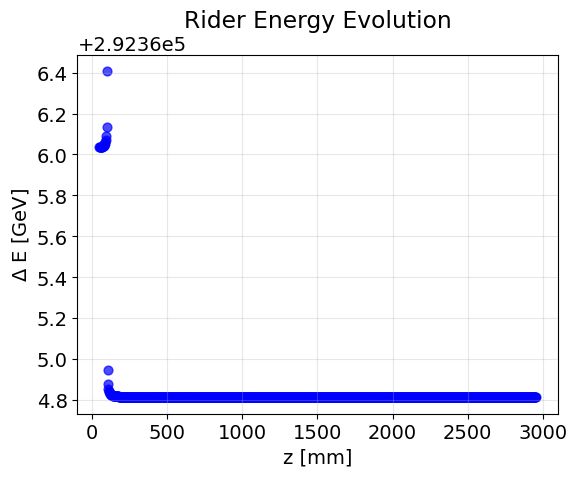

✅ Rider plot generated: 1001 data points
   Energy range: 292364.811002 to 292366.409575 GeV


In [18]:
# Generate First Plot - Rider Energy Evolution (ΔE vs z)

# Debug: Check trajectory structure
print("Trajectory structure analysis:")
print(f"Rider trajectory type: {type(rider_trajectory)}")
print(f"First element type: {type(rider_trajectory[0])}")
print(f"First element keys: {list(rider_trajectory[0].keys())}")
print(f"Number of particles: {len(rider_trajectory[0]['x'])}")

# Extract plotting data for rider (first particle from each trajectory point)
z_positions = [traj['z'][0] for traj in rider_trajectory]  # mm, first particle
energies = []

for traj in rider_trajectory:
    # Calculate total energy: E = √((pc)² + (mc²)²) for first particle
    Px, Py, Pz = traj['Px'][0], traj['Py'][0], traj['Pz'][0]
    mass_amu = traj['m'][0]
    
    # Convert momentum to energy (matching original calculation)
    momentum_total = np.sqrt(Px**2 + Py**2 + Pz**2)
    total_energy_mev = np.sqrt((momentum_total * c_ms * 1e-6)**2 + (mass_amu * 931.494)**2)
    
    # Energy change from rest energy
    delta_energy_mev = total_energy_mev - rider_energy_mev
    energies.append(delta_energy_mev)

# Convert to GeV for plotting (matching original)
delta_e_gev = np.array(energies) / 1000.0

# Create professional plot
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(z_positions, delta_e_gev, s=40, alpha=0.7, color='blue')
ax.set_ylabel(r"$\Delta$ E [GeV]")
ax.set_xlabel(r"z [mm]")
ax.set_title("Rider Energy Evolution")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Rider plot generated: {len(z_positions)} data points")
print(f"   Energy range: {delta_e_gev.min():.6f} to {delta_e_gev.max():.6f} GeV")

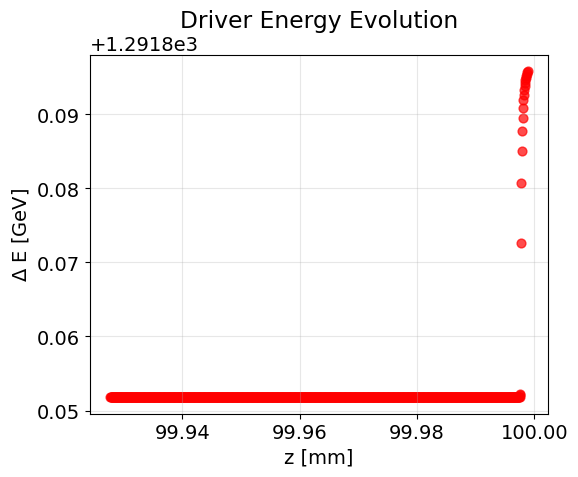

✅ Driver plot generated: 1001 data points
   Energy range: 1291.851773 to 1291.895849 GeV

📊 SIMULATION SUMMARY:
   Integration time: 12.45 seconds
   Rider trajectory: 1001 steps, Δz = 2904.42 mm
   Driver trajectory: 1001 steps, Δz = -0.07 mm
   ✅ Professional two-particle simulation completed successfully!


In [20]:
# Generate Second Plot - Driver Energy Evolution (ΔE vs z)

# Extract plotting data for driver (first particle from each trajectory point)  
z_positions_driver = [traj['z'][0] for traj in driver_trajectory]  # mm, first particle
energies_driver = []

for traj in driver_trajectory:
    # Calculate total energy for driver particle
    Px, Py, Pz = traj['Px'][0], traj['Py'][0], traj['Pz'][0]
    mass_amu = traj['m'][0]
    
    # Convert momentum to energy (matching original calculation)
    momentum_total = np.sqrt(Px**2 + Py**2 + Pz**2)
    total_energy_mev = np.sqrt((momentum_total * c_ms * 1e-6)**2 + (mass_amu * 931.494)**2)
    
    # Energy change from rest energy
    delta_energy_mev = total_energy_mev - driver_energy_mev
    energies_driver.append(delta_energy_mev)

# Convert to GeV for plotting (matching original)
delta_e_gev_driver = np.array(energies_driver) / 1000.0

# Create professional plot
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(z_positions_driver, delta_e_gev_driver, s=40, alpha=0.7, color='red')
ax.set_ylabel(r"$\Delta$ E [GeV]")
ax.set_xlabel(r"z [mm]")
ax.set_title("Driver Energy Evolution")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Driver plot generated: {len(z_positions_driver)} data points")
print(f"   Energy range: {delta_e_gev_driver.min():.6f} to {delta_e_gev_driver.max():.6f} GeV")

# Summary
print(f"\n📊 SIMULATION SUMMARY:")
print(f"   Integration time: {integration_time:.2f} seconds")
print(f"   Rider trajectory: {len(rider_trajectory)} steps, Δz = {z_positions[-1] - z_positions[0]:.2f} mm")
print(f"   Driver trajectory: {len(driver_trajectory)} steps, Δz = {z_positions_driver[-1] - z_positions_driver[0]:.2f} mm")
print(f"   ✅ Professional two-particle simulation completed successfully!")